<a href="https://colab.research.google.com/github/oradbarel/Fall-Prevention/blob/main/Fall_Prevention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fall Pervention - Data Analysis Document Review

### Table of Content:
1. [Background](#1)
2. [Creating a Dataset](#2)
3. [Choosing a Model](#3)
> 3.a. [Decision Tree](#3.a) <br>
> 3.b  [K-Nearest Neighbours](#3.b) <br>
> 3.c. [Convolutional Neural Network](#3.c) <br>
> 3.d. [Recurrent Neural Network](#3.d) <br>
> 3.e. [Conclusion](#3.e) <br>
4. [Creating Simulated Dataset](#4)
> 4.a. [Importing the libraries](#4.a) <br>
> 4.b. [Dataset Simulation](#4.b) <br>
> 4.c. [Exploring the Simulated Data](#4.c) <br>
5. [Building the Models](#5)
> 5.a. [Decision Tree](#5.a) <br>
> 5.b  [K-Nearest Neighbours](#5.b) <br>
> 5.c. [Convolutional Neural Network](#5.c) <br>
> 5.d. [Recurrent Neural Network](#5.d) <br>
> 5.e. [Conclusion](#5.e) <br>





<a name="1"></a> 
### 1. Background:

#### The Fall Prevention Project with Rambam Health Care Campus.

Patient falls occur in hospitals, and this is especially serious in cases that patients are undergone head surgery and sometimes do not act rationally. The purpose of this project is to alert the medical team of a patient who is about to fall and/or has fallen from their bed.

We will create a board with 8 force sensors (4 square sensors and 4 long sensors), 4 weight sensors, and ESP32 chip that will be put under the patient bed, and continuislly send data to the nurses workstation. <br>
Then the data will be analyzed using Machine Learning/Deep Learning model (that we will build and train) and predict patient falls.

TODO: add illustrations

<a name="2"></a> 
### 2. Creating a Dataset:

TODO

<a name="3"></a> 
### 3. Choosing a Model:

In order to predict the patient's current status (back lying, side lying, getting up), we should create a prediction model (Using Machine Learning or Deep Learning) which will use our dataset.<br>
Best suited models to our prediction problem:

<a name="3.a"></a> 
#### 3.a. Decision Tree:
Decision Tree is relatively simple Machine Learning model that uses features thresholds (e.g. value from our FS) in order to make a decision.<br>

High level flow chart of the DT:


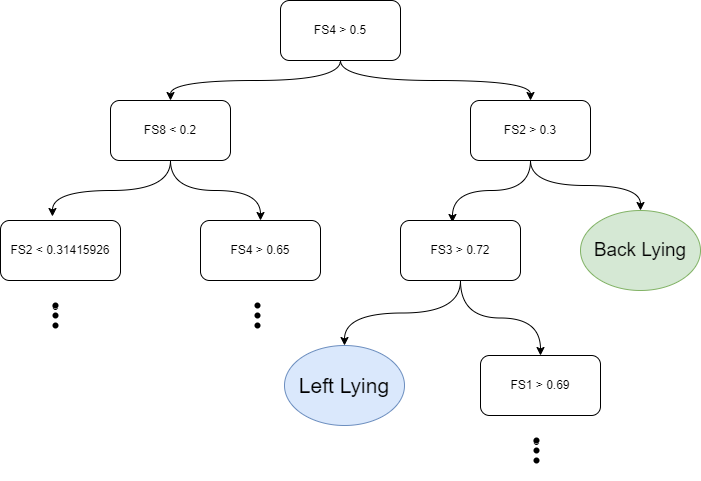


####Pros:
- Explainable - DT will make decisions that depends on the discreet values of our sensors.
- Fast decision making - Real time predictions at O(d) when d is the deepest node of the tree (WC)

####Cons:
- Work on only 1 sample to predict - The DT can only look at 1 sample (as set of features) at once
-  Might not be accurate - DT model predicts by horizontal and vertical separations.

<a name="3.b"></a> 
#### 3.b. K-Nearest Neighbours:
 K-Nearest Neighbours (KNN) is Machine Learning model make a decision by comparing a sample to it's closest samples in the training set.<br>


High level flow chart of the KNN:

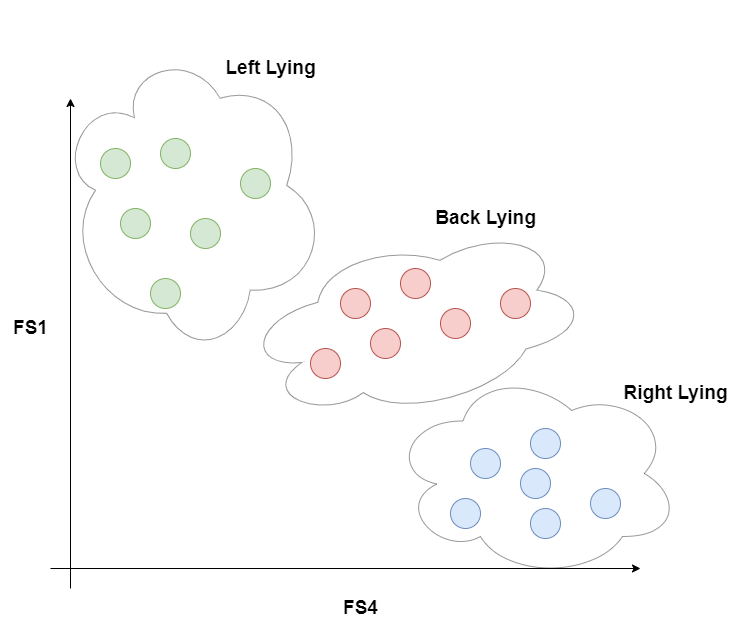


####Pros:
- Explainable - KNN will make decisions that depends on the discreet values of our sensors.

####Cons:
- Work on only 1 sample to predict - The DT can only look at 1 sample (as set of features) at once
- Heavy on Storage and prediction - this model (KNN) not really train, as it compare new sample to all of the training set each time.

<a name="3.c"></a> 
#### 3.c. Convolutional Neural Network:
Convolutional Neural Network is a Deep Learning model that uses Deep Neural Networks that make a decision by looking at window of data samples on given time.<br>



High level flow chart of the CNN:

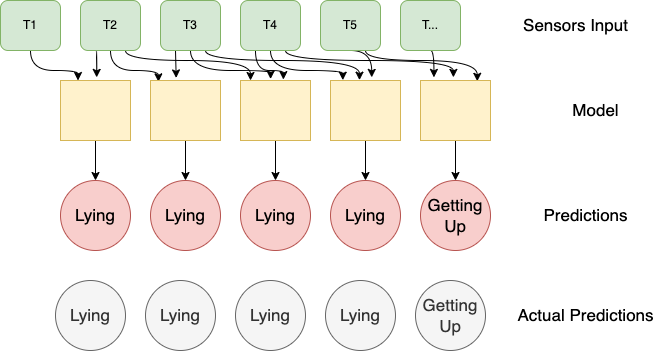


####Pros:
- High expexted prediction rate - more complex, non-linear function can be learned
- Works on data streams - Use series of time adjacent samples in order to make the predictions

####Cons:
- Zero to no explainability - Known problem of DNNs
- Harder to train - Require rich dataset and heavy compute equipment

<a name="3.d"></a> 
#### 3.d.  Recurrent Neural Network:
Recurrent Neural Network is a Deep Learning model that uses Deep Neural Networks that can pass NN data from past samples to the next, and by that, tries to give a better predictions.<br>

High level flow chart of the RNN:

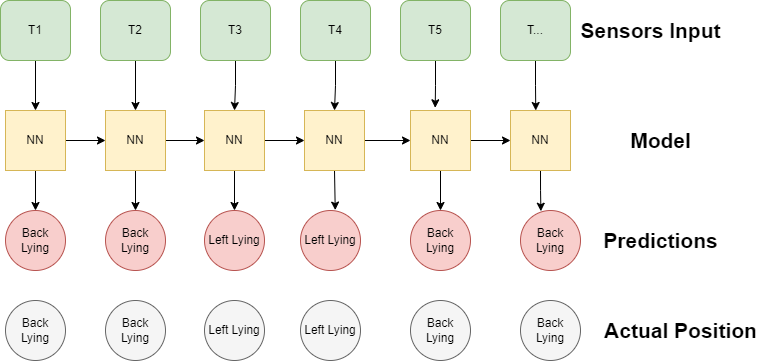

####Pros:
- High expected prediction rate - more complex, non-linear function can be learned
- Works on data streams - Will let us predict falling patterns

####Cons:
- Zero to no explainability - Known problem of DNNs
- Harder to train - Require rich dataset and heavy compute equipment

<a name="3.e"></a> 
#### 3.e.  Conclusion:

RNN/CNN seems to be the Ideal models the our prediction problem, as it's the only option that let us use data streams.

<a name="4"></a> 
### 4.  Creating Simulated Dataset:


<a name="4.a"></a> 
#### 4.a. Importing the libraries
We'll use Matplotlib for our charts, Numpy, Pandas, Seaborn for the data and calculations, and Tensorflor for the Neural Network.

In [41]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

<a name="4.b"></a> 
#### 4.b. Dataset Simulation
To Simulate the sensors data, we can use the data set from https://physionet.org/content/pmd/1.0.0/.

Each sample from this dataset discribes a value of pressure sensor, from 32x64 sensors matrix, thats lying under a patient bed.

In [42]:
!wget https://physionet.org/static/published-projects/pmd/a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip
!unzip -q a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip
!mv a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0 dataset 

--2022-11-15 20:17:37--  https://physionet.org/static/published-projects/pmd/a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107315828 (102M) [application/zip]
Saving to: ‘a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip.1’

a-pressure-map-data 100%[===================>] 102.34M  8.10MB/s    in 14s     

2022-11-15 20:17:51 (7.14 MB/s) - ‘a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip.1’ saved [107315828/107315828]



Libraries for are simulation:

In [43]:
import torch
import os
from torchvision import transforms
import copy
from time import sleep as zzz
from IPython.display import clear_output

**Auxiliary Constants, Definitions and Functions:**

In [44]:
# Main data folder
data_path = './dataset/experiment-i/'

"""
Classification order of the sample files:
0 - back lynig, 1 - right lying, 2 - left lying
"""
pos_order = [0, 0, 1, 2, 1, 1, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0]

# Will consist all of the raw data
data = {}

# Extracting patients weight
weight_file_path = os.path.join(data_path, 'subject-info-i.csv')
weights = pd.read_csv(weight_file_path, encoding="utf-16")

# Sensors that we will use to simulate our system
square_sensors = [(12,15), (12,17), (18,15), (18,17)]
line_sensors = [(12, 18, 8), (12, 18, 12), (12, 18, 20), (12, 18, 24)]

"""
@ get_time_series_df:
@ args:
@   - X: dataframe samples
@   - y: dataframe labels
@   - length: come on
@   - step: obvious 
@
@ returns:  time series dataframe
"""
def get_time_series_df(X, y, length = 5):
  ts_X, ts_y = [], []
  for l in range(0, len(X) - length, length):
    ts_X.append(X[l:l + length])
    ts_y.append(y[l + length-1])

  return np.array(ts_X), np.array(ts_y)

"""
@ paint_sensors: Paint sub-group of sensors that simulate our system
@ arg: sample - 64x32 matrix representing force sensors image
@ returns: None
"""
def paint_sensors(sample):
  for sensor in square_sensors:
    sample[sensor[0]][sensor[1]] = 1
  for sensor in line_sensors:
    for i in range(sensor[0], sensor[1] + 1):
      sample[i][sensor[2]] = 1


Creating the (simulated) dataset:

In [45]:
# For each Patient dir
for dir in os.listdir(data_path):
  if os.path.isfile(os.path.join(data_path, dir)):
    continue

  new_data, labels = None, None

  # For each data file
  for file in os.listdir(os.path.join(data_path, dir)):
    with open(os.path.join(data_path, dir, file), 'r') as f:
      for line in f.read().splitlines()[3:]:
        raw_data = np.fromstring(line, dtype=float, sep='\t')
        file_data = np.round((raw_data*255)/1000).astype(np.uint8)
        Normalize = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])
        file_data = Normalize(file_data.reshape(64,32))
        file_data = file_data.view(1, 64, 32)
        file_label = np.array([pos_order[int(file[:-4])]])

        # First data
        if new_data is None:
          new_data = file_data
          labels = file_label
        else:
          new_data = np.concatenate((new_data, file_data), axis=0)
          labels = np.concatenate((labels, file_label), axis=0)

  data[dir] = (torch.from_numpy(new_data), torch.from_numpy(labels))

Visualisation of the sensors layout we will use in our dataset:

Text(0.5, 1.0, "Sensors that we'll use (in yellow)")

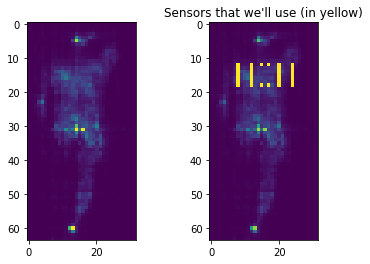

In [46]:
sample = copy.deepcopy(data['S2'][0].numpy()[300])
paint_sensors(sample)

f, pl = plt.subplots(1, 2)
pl[0].imshow(data['S2'][0].numpy()[300])
pl[1].imshow(sample)

plt.title("Sensors that we'll use (in yellow)")

Code for visualise the patient's position over the time:

In [47]:
"""
for i in data['S2'][0].numpy():
  plt.imshow(i)
  plt.show()
  clear_output(wait=True)
"""

"\nfor i in data['S2'][0].numpy():\n  plt.imshow(i)\n  plt.show()\n  clear_output(wait=True)\n"

Creating the actual simulated dataset:
Each sample in the dataset will consist:
- sensors[0-7]
- patient weight
- trinary label (0 - back lynig, 1 - right side lying, 2 - left side lying)

In [48]:
from sklearn.preprocessing import MinMaxScaler

df_labels = ["FS0", "FS1", "FS2", "FS3", "FS4", "FS5", "FS6", "FS7", "Weight", "Pos"]
dataset = []

def get_line_sensors(sample):
  res = []
  for sensor in line_sensors:
    value = 0
    for i in range(sensor[0], sensor[1] + 1):
      value += sample[i][sensor[2]]
    res.append(value)
  return res

for patient in data.keys():
  patient_weight = weights['Weight/kg'][int(patient[1:]) - 1]
  sample = data[patient][0].numpy()
  for i, s in enumerate(sample):
    to_add = [s[sensor[0]][sensor[1]] for sensor in square_sensors]
    to_add += get_line_sensors(s)
    to_add.append(patient_weight)
    to_add.append(data[patient][1][i].item())
    dataset.append(to_add)

df = pd.DataFrame(dataset, columns = df_labels)
scaler = MinMaxScaler(feature_range=(0, 1))

df[["FS0", "FS1", "FS2", "FS3", "FS4", "FS5", "FS6", "FS7", "Weight"]] = scaler.fit_transform(df[["FS0", "FS1", "FS2", "FS3", "FS4", "FS5", "FS6", "FS7", "Weight"]])

Dataset sample - Sanity check:

We can see that the for each row of our force sensors, we get values that get bigger (left to right) because our patient in this case is lying on the right side of it's bed.

,FS0,FS1,FS2,FS3,FS4,FS5,FS6,FS7,Weight,Pos
0,0.330097,0.105023,0.060773,0.007092,0.165007,0.335,0.051527,0.051355,0.297297,1
1,0.330097,0.109589,0.060773,0.007092,0.169275,0.335,0.053435,0.049929,0.297297,1
2,0.325243,0.109589,0.066298,0.014184,0.166430,0.340,0.057252,0.051355,0.297297,1
3,0.325243,0.105023,0.060773,0.007092,0.162162,0.344,0.051527,0.049929,0.297297,1
4,0.330097,0.105023,0.066298,0.007092,0.167852,0.347,0.055344,0.052782,0.297297,1


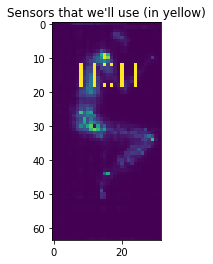

In [49]:
sample = copy.deepcopy(data[list(data.keys())[0]][0].numpy()[5])
paint_sensors(sample)
plt.imshow(sample)
plt.title("Sensors that we'll use (in yellow)")
df.head()

<a name="4.c"></a> 
#### 4.c. Let's explore our data a little bit further:

We can clearly see that when the patient is lying on is back, our patient's weight is devided between the force sensors equally (more or less).

Also, When the patient is lying on his/hers side, we can see that the force sensors on coresponding side are also report bigger number on average.

(When the patient is on the left, we see higer numbers on FS0, FS4<br>
and when the patient is on the right, we see higer numbers on FS3, FS7)

Text(0.5, 1.0, 'Sensors values when left lying')

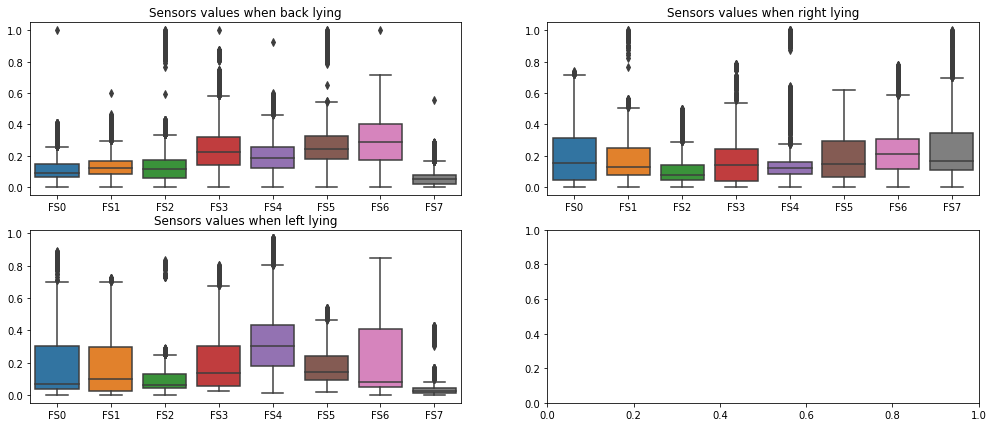

In [50]:
f, pl = plt.subplots(2, 2, figsize=(17, 7))

tmpdf0 = df[df.Pos == 0]
tmpdf1 = df[df.Pos == 1]
tmpdf2 = df[df.Pos == 2]

sns.boxplot(ax = pl[0][0], data=tmpdf0.loc[:,['FS0', 'FS1', 'FS2', 'FS3', 'FS4', 'FS5', 'FS6', 'FS7']])
sns.boxplot(ax = pl[0][1], data=tmpdf1.loc[:,['FS0', 'FS1', 'FS2', 'FS3', 'FS4', 'FS5', 'FS6', 'FS7']])
sns.boxplot(ax = pl[1][0], data=tmpdf2.loc[:,['FS0', 'FS1', 'FS2', 'FS3', 'FS4', 'FS5', 'FS6', 'FS7']])

pl[0][0].set_title("Sensors values when back lying")
pl[0][1].set_title("Sensors values when right lying")
pl[1][0].set_title("Sensors values when left lying")

Number of samples for each position:

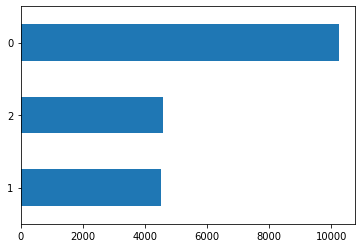

In [51]:
df.Pos.value_counts().sort_values().plot(kind = 'barh')

<a name="5"></a> 
### 5.Building the Models

We will split the dataset in 80:20 ratio (training:testing)

In [52]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)
print(train.shape, test.shape)

X_train = train.iloc[:,range(9)]
y_train = train["Pos"]

X_test = test.iloc[:,range(9)]
y_test = test["Pos"]

(15488, 10) (3873, 10)


<a name="5.a"></a> 
#### 5.a. Decision Tree:

In [53]:
from sklearn.tree import DecisionTreeClassifier

h = DecisionTreeClassifier(criterion="entropy")
h.fit(X_train, y_train)

trainAcc = np.sum(h.predict(X_train) == y_train) * 100 / len(y_train)
testAcc = np.sum(h.predict(X_test) == y_test) * 100 / len(y_test)

print("Train Accuracy: {:.1f}%, Test Accuracy: {:.1f}%".format(trainAcc, testAcc))

Train Accuracy: 100.0%, Test Accuracy: 99.8%


The Test Accuracy is relativly low.
Let's look at the actuall tree we got:

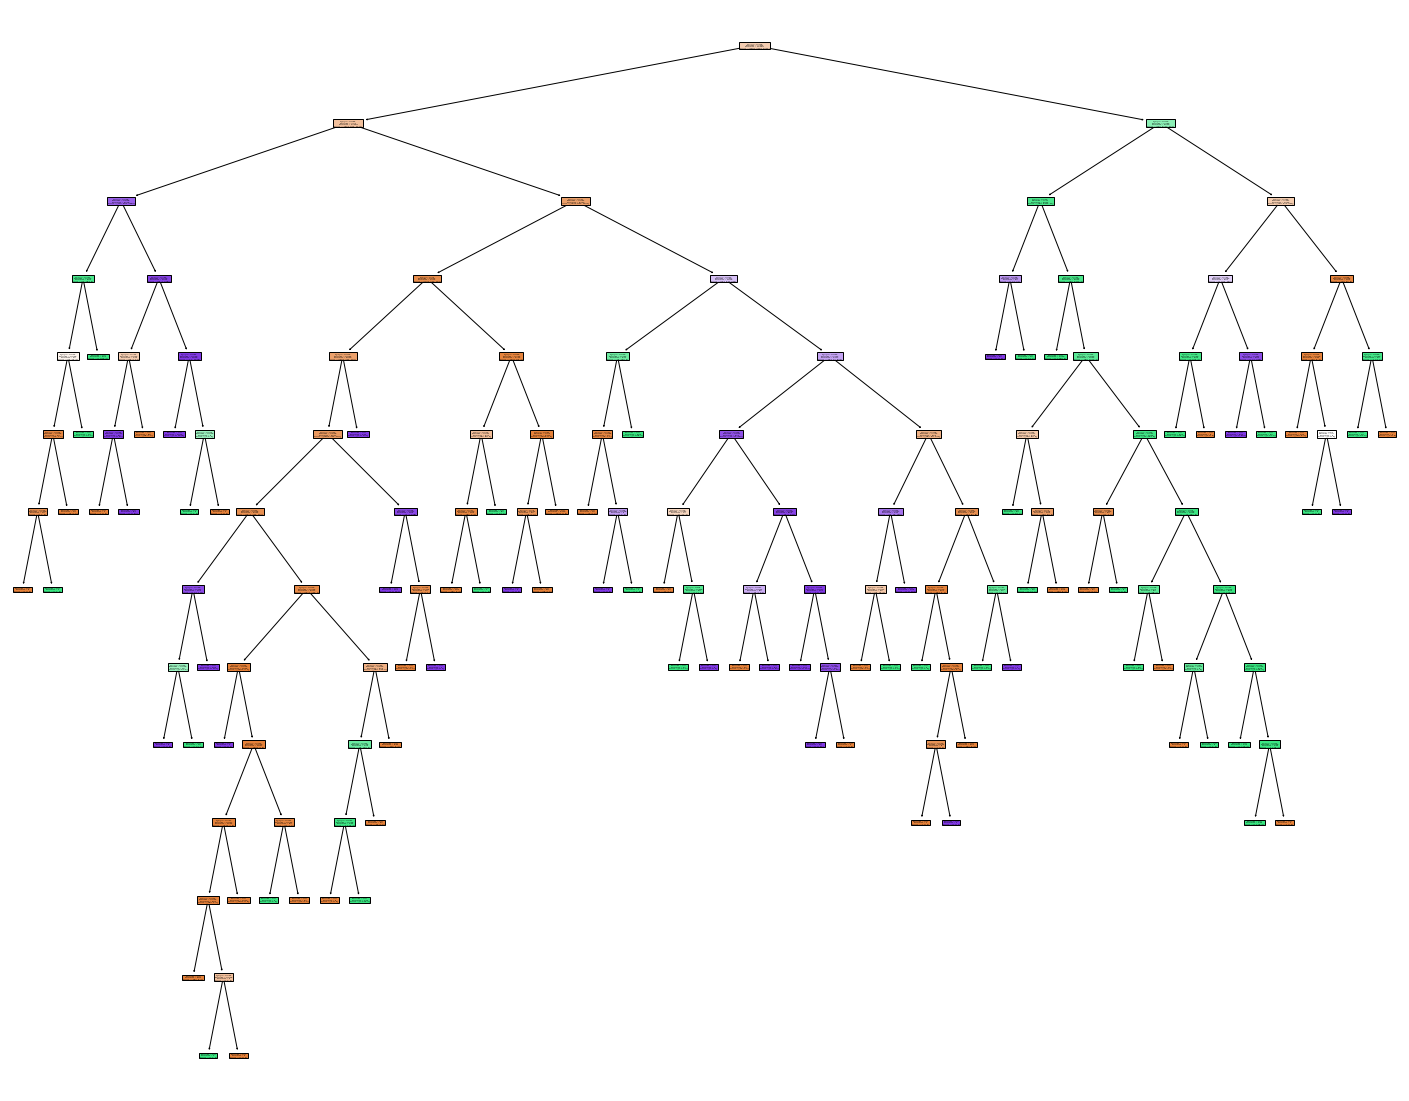

In [54]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(25,20))
_ = plot_tree(h, filled=True)

We can see that in order to maintain higher Train accuracy, our model reached to greater depths. <br>
Let's try to limit the depth this time:

In [55]:
h = DecisionTreeClassifier(criterion="entropy", max_depth=10)
h.fit(X_train, y_train)

trainAcc = np.sum(h.predict(X_train) == y_train) * 100 / len(y_train)
testAcc = np.sum(h.predict(X_test) == y_test) * 100 / len(y_test)

print("Train Accuracy: {:.1f}%, Test Accuracy: {:.1f}%".format(trainAcc, testAcc))

Train Accuracy: 100.0%, Test Accuracy: 99.8%


<a name="5.b"></a> 
#### 5.b. K-Nearest Neighbors:

In [56]:
from sklearn.neighbors import KNeighborsClassifier

h = KNeighborsClassifier()
h.fit(X_train, y_train)

trainAcc = np.sum(h.predict(X_train) == y_train) * 100 / len(y_train)
testAcc = np.sum(h.predict(X_test) == y_test) * 100 / len(y_test)

print("Train Accuracy: {:.1f}%, Test Accuracy: {:.1f}%".format(trainAcc, testAcc))

Train Accuracy: 100.0%, Test Accuracy: 100.0%


<a name="5.c"></a> 
#### 5.c. Convolutional Neural Network:

We will use 3 layers of Convolution, with normalization layers between them

In [57]:
import keras
from keras.models import Sequential
from keras.layers import Conv1D, BatchNormalization, Dense, Flatten, Input
from sklearn.metrics import mean_squared_error

model = Sequential()
model.add(Input((5, 9)))
model.add(Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=3, padding="same"))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(3))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 5, 64)             1792      
                                                                 
 batch_normalization_2 (Batc  (None, 5, 64)            256       
 hNormalization)                                                 
                                                                 
 conv1d_4 (Conv1D)           (None, 5, 64)             12352     
                                                                 
 batch_normalization_3 (Batc  (None, 5, 64)            256       
 hNormalization)                                                 
                                                                 
 conv1d_5 (Conv1D)           (None, 5, 32)             6176      
                                                                 
 flatten_1 (Flatten)         (None, 160)              

Let's look the the NN we got:

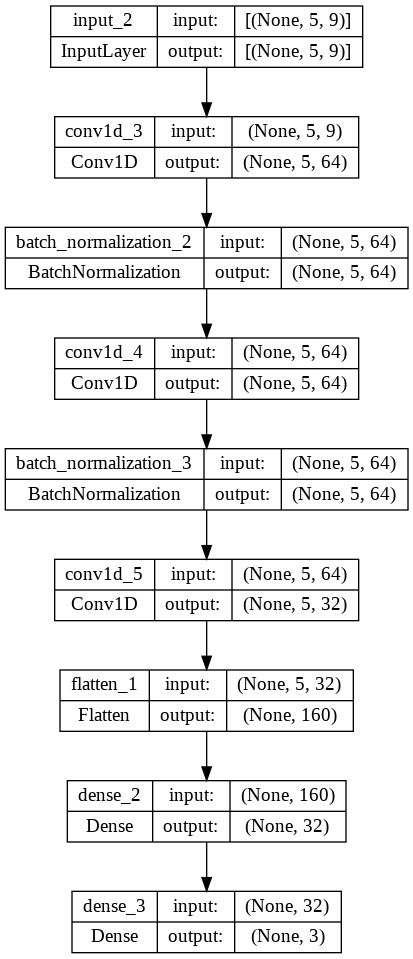

In [58]:
keras.utils.plot_model(model, show_shapes=True)

Training our CNN:

In [65]:
X_sequence, y = get_time_series_df(df.loc[:, "FS0":"Weight"].values, df.Pos)

training_size = int(len(X_sequence) * 0.8)

X_train, y_train = X_sequence[:training_size], y[:training_size]
X_test, y_test = X_sequence[training_size:], y[training_size:]

model.fit(X_train, y_train, batch_size=5, epochs=32)

Epoch 1/32
620/620 [==============================] - 6s 8ms/step - loss: 0.0645 - accuracy: 0.9832
Epoch 2/32
620/620 [==============================] - 3s 4ms/step - loss: 0.0548 - accuracy: 0.9858
Epoch 3/32
620/620 [==============================] - 3s 4ms/step - loss: 0.0529 - accuracy: 0.9871
Epoch 4/32
620/620 [==============================] - 3s 5ms/step - loss: 0.0487 - accuracy: 0.9871
Epoch 5/32
620/620 [==============================] - 2s 4ms/step - loss: 0.0456 - accuracy: 0.9884
Epoch 6/32
620/620 [==============================] - 2s 3ms/step - loss: 0.0432 - accuracy: 0.9881
Epoch 7/32
620/620 [==============================] - 3s 5ms/step - loss: 0.0422 - accuracy: 0.9871
Epoch 8/32
620/620 [==============================] - 2s 3ms/step - loss: 0.0368 - accuracy: 0.9913
Epoch 9/32
620/620 [==============================] - 2s 3ms/step - loss: 0.0326 - accuracy: 0.9910
Epoch 10/32
620/620 [==============================] - 2s 3ms/step - loss: 0.0320 - accuracy: 0.9910

Let's test the model we got:

In [66]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

y_train_pred = probability_model.predict(X_train)
y_train_pred = [np.argmax(i) for i in y_train_pred]

y_test_pred = probability_model.predict(X_test)
y_test_pred =  [np.argmax(i) for i in y_test_pred]

trainAcc = np.sum(y_train_pred == y_train) * 100 / len(y_train)
testAcc = np.sum(y_test_pred == y_test) * 100 / len(y_test)

print("Train Accuracy: {:.1f}%, Test Accuracy: {:.1f}%".format(trainAcc, testAcc))

25/25 [==============================] - 0s 3ms/step
Train Accuracy: 100.0%, Test Accuracy: 91.7%


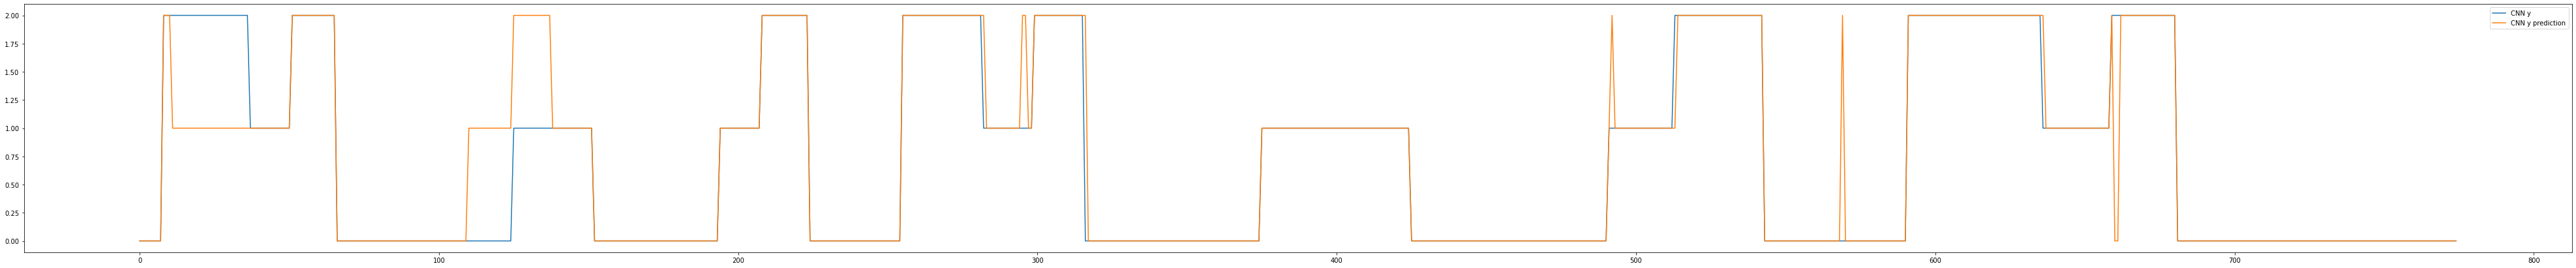

In [67]:
dataset = pd.DataFrame()

dataset["CNN y"] = y_test
dataset["CNN y prediction"] = y_test_pred

dataset.plot(figsize=(70, 7))

Not so bad, given the poor dataset.

<a name="5.d"></a> 
#### 5.d. Recurrent Neural Network:

We will use only one layer of RNN:

In [68]:
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from sklearn.metrics import mean_squared_error

model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(5, 9), activation="relu"))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 32)                1344      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1,443
Trainable params: 1,443
Non-trainable params: 0
_________________________________________________________________


Let's look at the model we got:

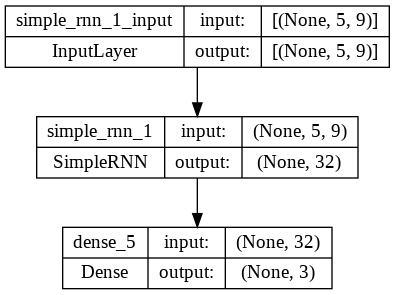

In [69]:
keras.utils.plot_model(model, show_shapes=True)

Train our model:

In [70]:
X_sequence, y = get_time_series_df(df.loc[:, "FS0":"Weight"].values, df.Pos)

training_size = int(len(X_sequence) * 0.8)

X_train, y_train = X_sequence[:training_size], y[:training_size]
X_test, y_test = X_sequence[training_size:], y[training_size:]

model.fit(X_train, y_train, batch_size=5, epochs=32)

Epoch 1/32


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


620/620 [==============================] - 3s 3ms/step - loss: 0.5833 - accuracy: 0.7724
Epoch 2/32
620/620 [==============================] - 3s 5ms/step - loss: 0.2478 - accuracy: 0.9235
Epoch 3/32
620/620 [==============================] - 2s 3ms/step - loss: 0.1809 - accuracy: 0.9477
Epoch 4/32
620/620 [==============================] - 2s 3ms/step - loss: 0.1424 - accuracy: 0.9642
Epoch 5/32
620/620 [==============================] - 2s 3ms/step - loss: 0.1250 - accuracy: 0.9729
Epoch 6/32
620/620 [==============================] - 2s 3ms/step - loss: 0.1105 - accuracy: 0.9751
Epoch 7/32
620/620 [==============================] - 2s 3ms/step - loss: 0.1002 - accuracy: 0.9784
Epoch 8/32
620/620 [==============================] - 2s 3ms/step - loss: 0.0936 - accuracy: 0.9800
Epoch 9/32
620/620 [==============================] - 2s 4ms/step - loss: 0.0870 - accuracy: 0.9774
Epoch 10/32
620/620 [==============================] - 2s 3ms/step - loss: 0.0762 - accuracy: 0.9832
Epoch 11/3

In [71]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

y_train_pred = probability_model.predict(X_train)
y_train_pred = [np.argmax(i) for i in y_train_pred]

y_test_pred = probability_model.predict(X_test)
y_test_pred =  [np.argmax(i) for i in y_test_pred]

trainAcc = np.sum(y_train_pred == y_train) * 100 / len(y_train)
testAcc = np.sum(y_test_pred == y_test) * 100 / len(y_test)

print("Train Accuracy: {:.1f}%, Test Accuracy: {:.1f}%".format(trainAcc, testAcc))

25/25 [==============================] - 0s 2ms/step
Train Accuracy: 99.7%, Test Accuracy: 88.0%


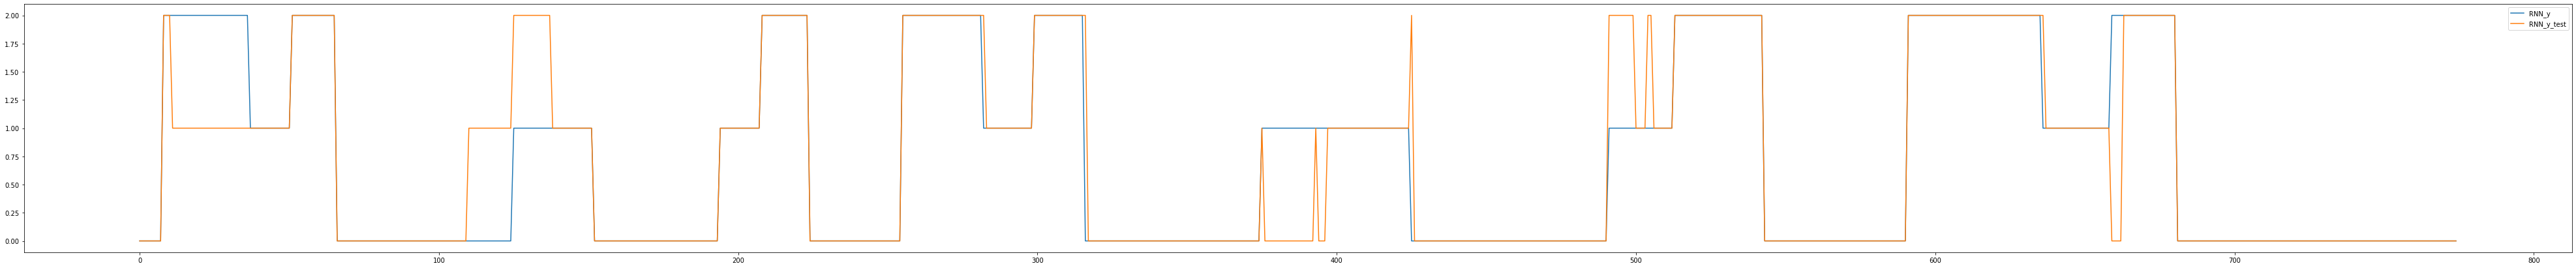

In [72]:
dataset = pd.DataFrame()

dataset["RNN_y"] = y_test
dataset["RNN_y_test"] = y_test_pred

dataset.plot(figsize=(70, 7))

Because our simulated dataset isn't really continuous, we can see lower prediction rates in this model, but still not so bad.